# Leaf Instance Segmentation using maskRCNN (with a pre-trained model)

Instance segmentation is identifying each object instance for every known object within an image. Instance segmentation assigns a label to each pixel of the image. It can be used for tasks such as counting the number of objects. 

Instance segmentation requires:

1. Object detection of all objects in an image. For object detection, the goal is to classify individual objects and localize each object instance using a bounding box.
2. Segmenting each instance. For segmentation the goal is to classify each pixel into a fixed set of categories without differentiating object instances. 

Taking an image of an arabidopsis plant as an example. As shown in the image below, the 1st image is an RGB image of an arabidopsis. There are two categories present in this image: (arabidopsis) plant and background. The image in the middle is an example of objection segmentation result, the pixels considered to be object (plant) are detected and segmented out. The 3rd image is the result of instance segmentation. 


<table><tr>
<td> <img src="doc_img/original.jpg" alt="Drawing" width="250"/> </td>
<td> <img src="doc_img/threshold.jpg" alt="Drawing" style="width: 250px;"/> </td>
<td> <img src="doc_img/instance_seg.jpg" alt="Drawing" style="width: 250px;"/> </td>    
</tr></table>

It is easy to tell that the goal for image segmentation is to have pixel level labels indicating "plant" or "not plant" for every pixel, and the output for image segmentation is a binary mask indicating where the plant is in the image. At this point we have no information regarding number of leaves in this image. 

While for instance segmentation, as shown in the 3rd image, we can see that the goal is to segment out every leaf (hence, there is a label for every leaf, e.g. leaf 1, leaf 2, etc.) instance. In this specific example, 5 binary masks would be generated, every one represents for one leaf. Hence we are also able to tell that there are 5 leaves present in this image. 

There are plenty of methods for instance segmentation, arabidopsis leaf instance segmentation using maskRCNN is shown here as an example. 

For detailed information regrading maskRCNN, please check here:
https://github.com/matterport/Mask_RCNN

### Installation of maskRCNN to your PC or workstation
Follow the installation steps to create a conda environment for mask_rcnn and install necessary packages.

- Create a conda environment with tensorflow 1.13.1 and keras 2.1.0.
    - Open a terminal window, type:
    ```
    conda create -n mrcnn tensorflow=1.13.1
    conda activate mrcnn
    pip install keras==2.1.0
    conda install plantcv # install plantcv tools for this environment
```
This would create a tensorflow environment (with tensorflow 1.13.1 and keras 2.1.0, those are required by the MaskRCNN package we are to install) with a name of mrcnn. You are free to change the name "mrcnn" based on you own preference. 

- Install MaskRCNN
    - Clone [this](https://github.com/matterport/Mask_RCNN) github repository to your desired location. (It is suggested to put the same directory as you put your plantcv folder)
    - Open a terminal, follow the instructions below:
    
```
    cd Mask_RCNN # direct yourself to the folder of Mask_RCNN
    pip install -r requirements.txt # install dependencies
    python3 setup.py install # run setup
```   

After you finish setting up this conda environment and package installation, you can clone [this](https://github.com/danforthcenter/plantcv-tutorial_leaf_instance_segmentation) repository with test images included. And use this notebook to test on test images or your own images.

### Try our interactive tutorial!
Alternatively, you can also refer to this interactive tutorial: 
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/danforthcenter/plantcv-tutorial_leaf_instance_segmentation/a5a0c08aa9b2d8d3db078a58cec3b64d0a9f8ccf?filepath=doc_leaf_instance_segmentation.ipynb)
https://mybinder.org/v2/gh/danforthcenter/plantcv-tutorial_leaf_instance_segmentation/16583a0748a17c8d1fe93cb8ff14276caea01f6d
And you can explore the repository [here](https://mybinder.org/v2/gh/danforthcenter/plantcv-tutorial_leaf_instance_segmentation/master). (Note: If you would like to upload your own test images, you should use this link to upload images, and open this "doc_leaf_instance_segmentation.ipynb" notebook.)

With conda environment mrcnn activated (```conda activate mrcnn```), you are ready to get instance level segmentation with Mask_RCNN using a pre-trained model. Follow the step below to download this pre-trained model.


In [1]:
import requests
url             = 'https://datasci.danforthcenter.org/mask_rcnn_leaves_0060.h5'
open('./model.h5', 'wb').write(requests.get(url).content)


179179456

At this point you will find a file called "model.h5" in the current folder. 

Now you can follow this notebook for step-by-step implementation of leaf instance segmentation.

In [2]:
# import packages 
import os
import inferencing_utilities as funcs

/home/hsheng/miniconda3/envs/mrcnn/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/hsheng/miniconda3/envs/mrcnn/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/hsheng/miniconda3/envs/mrcnn/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/hsheng/miniconda3/envs/mrcnn/lib/python3

### Instance segmentation

The following block is where you want to change based on your own application:

Some detailed regarding parameters "suffix":
The image names in the "test_img" folder either end with "img11.jpg" or "img17.jpg", and in this specific case different numbers represent for different plants. To make sure we include same plant for the experiment, we have to define the plant by the parameter "suffix". The example here shows the analysis for plant 17.

In [3]:
## suffix of original image files. Make sure that all files have the same suffix format
suffix = 'crop-img17.jpg'

## pattern for the date-tima part in your data. Make sure that the date-time part in all filenames follow the same pattern
pattern_datetime = '\d{4}-\d{2}-\d{2}-\d{2}-\d{2}'

## directory of original images
imagedir = 'test_img'

## desired saving directory for results
savedir = 'result/segmentation'
if not os.path.exists(savedir):
    os.makedirs(savedir)

## class names. Since a pre-trained model is used here, and the model is trained with 2 classes: either "Background" or "Leaf", there is really nothing to change here
class_names = ['BG', 'Leaf']

In [4]:
## Root directory of the project
rootdir = os.path.abspath("./")

## initialize the instance segmentation
instance_seg =  funcs.instance_seg_inferencing(imagedir, savedir, rootdir, pattern_datetime, suffix, class_names)

## get configuration for instance segmentation
instance_seg.get_configure()

## load the pre-trained model
instance_seg.load_model()

## pre-define colors for visualization used later
instance_seg.define_colors()

## get the list of all files
instance_seg.get_file_list()

## option (print the file list)
instance_seg.list_f

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.
Loading weights  /shares/mgehan_share/hsheng/plantcv-tutorial_leaf_instance_segmentation/model.h5
There are 12 images.


['10.9.1.241_pos-165-003-020_2019-10-22-11-05_crop-img17.jpg',
 '10.9.1.241_pos-165-003-020_2019-10-23-11-05_crop-img17.jpg',
 '10.9.1.241_pos-165-003-020_2019-10-24-11-05_crop-img17.jpg',
 '10.9.1.241_pos-165-003-020_2019-10-25-11-05_crop-img17.jpg',
 '10.9.1.241_pos-165-003-020_2019-10-26-11-05_crop-img17.jpg',
 '10.9.1.241_pos-165-003-020_2019-10-27-11-05_crop-img17.jpg',
 '10.9.1.241_pos-165-003-020_2019-10-28-11-05_crop-img17.jpg',
 '10.9.1.241_pos-165-003-020_2019-10-29-11-05_crop-img17.jpg',
 '10.9.1.241_pos-165-003-020_2019-10-30-11-05_crop-img17.jpg',
 '10.9.1.241_pos-165-003-020_2019-10-31-11-05_crop-img17.jpg',
 '10.9.1.241_pos-165-003-020_2019-11-01-11-05_crop-img17.jpg',
 '10.9.1.241_pos-165-003-020_2019-11-02-11-05_crop-img17.jpg']

For the next block, a randomly selected example is used to show the instance segmentation result

Processing 1 images
image                    shape: (501, 501, 3)         min:    0.00000  max:  173.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:   54.20000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32


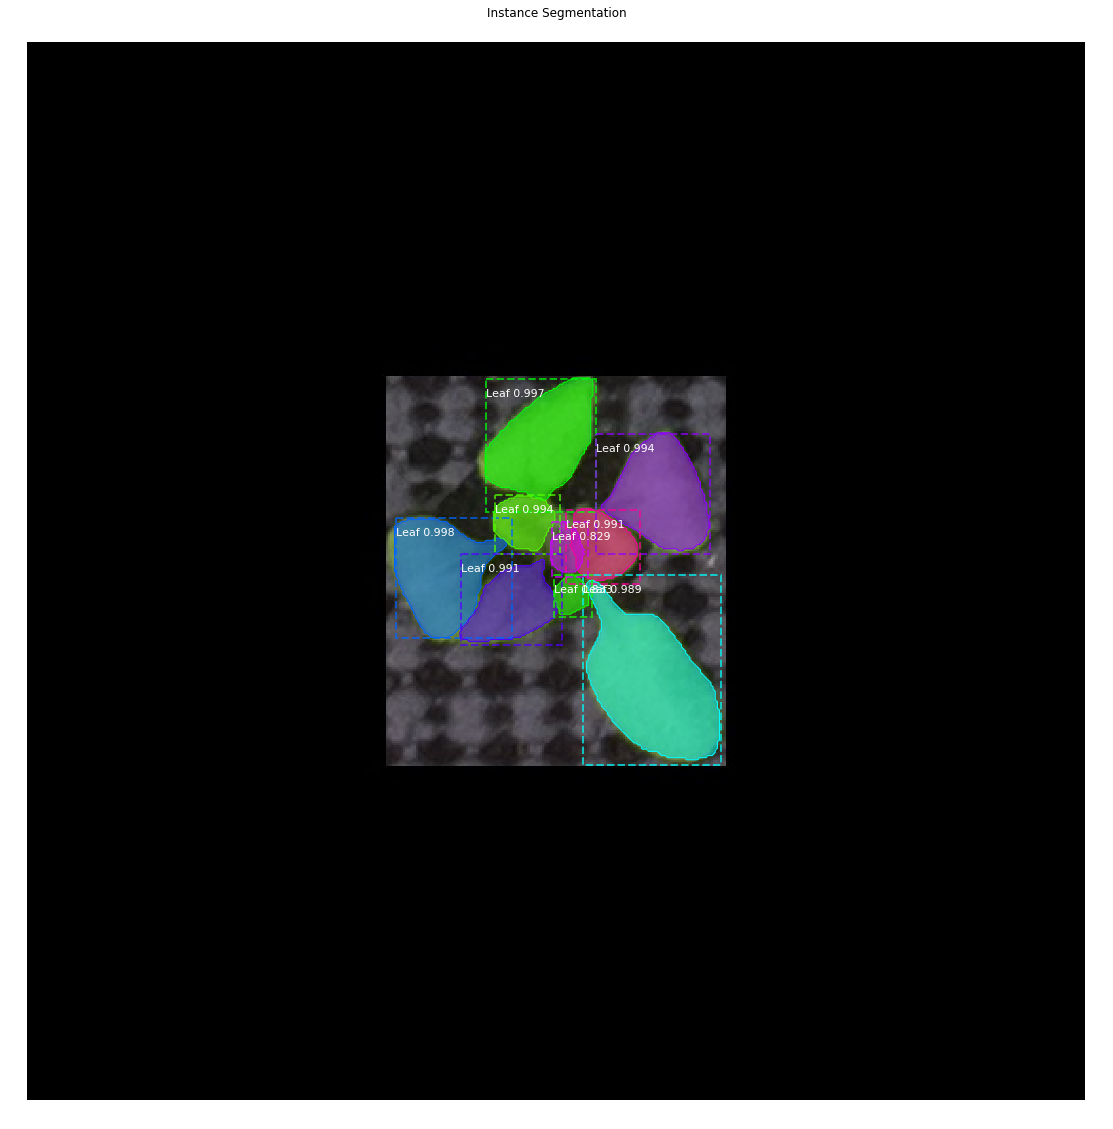

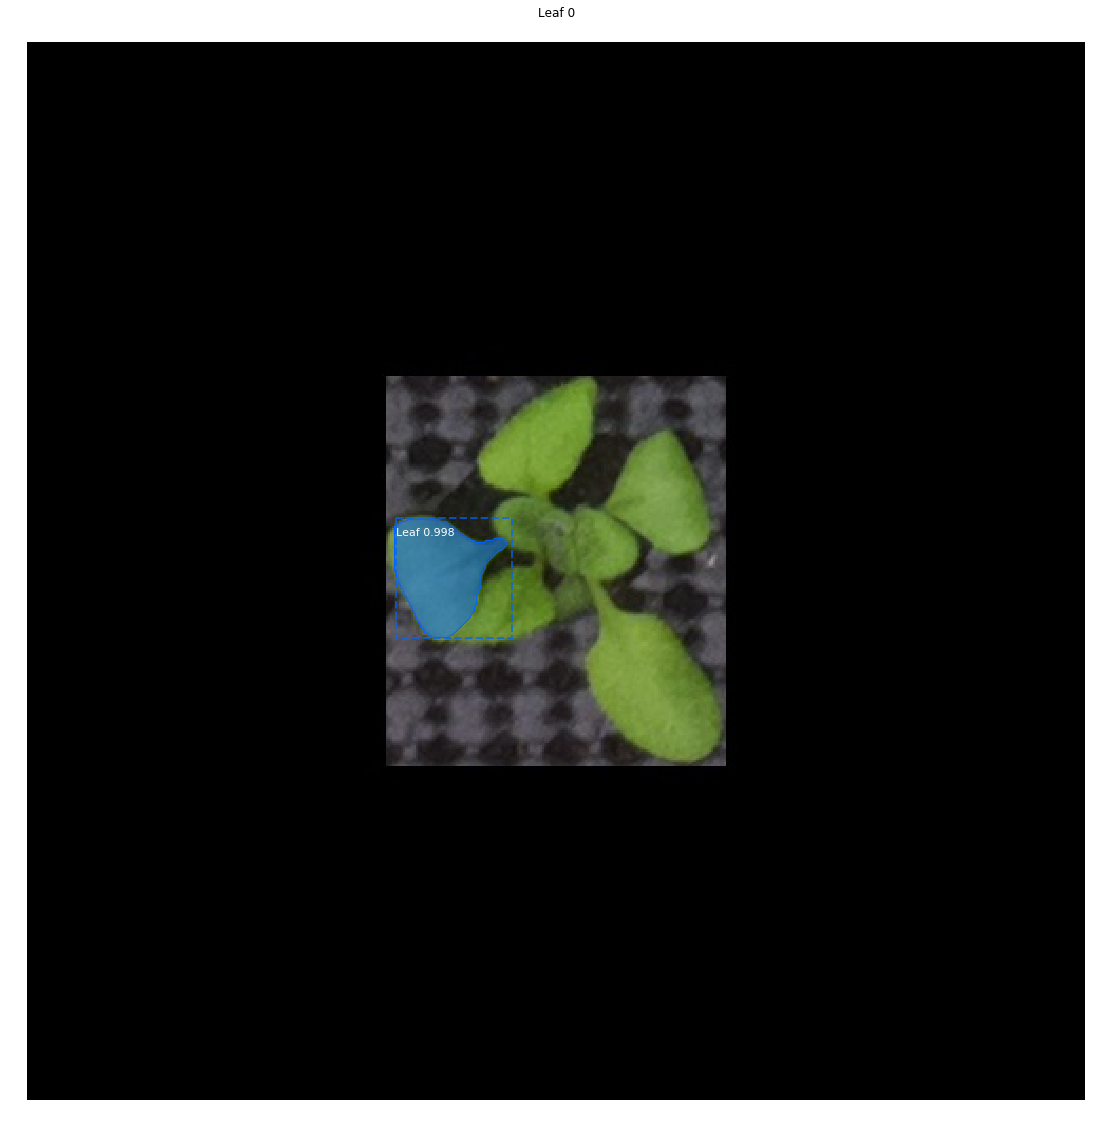

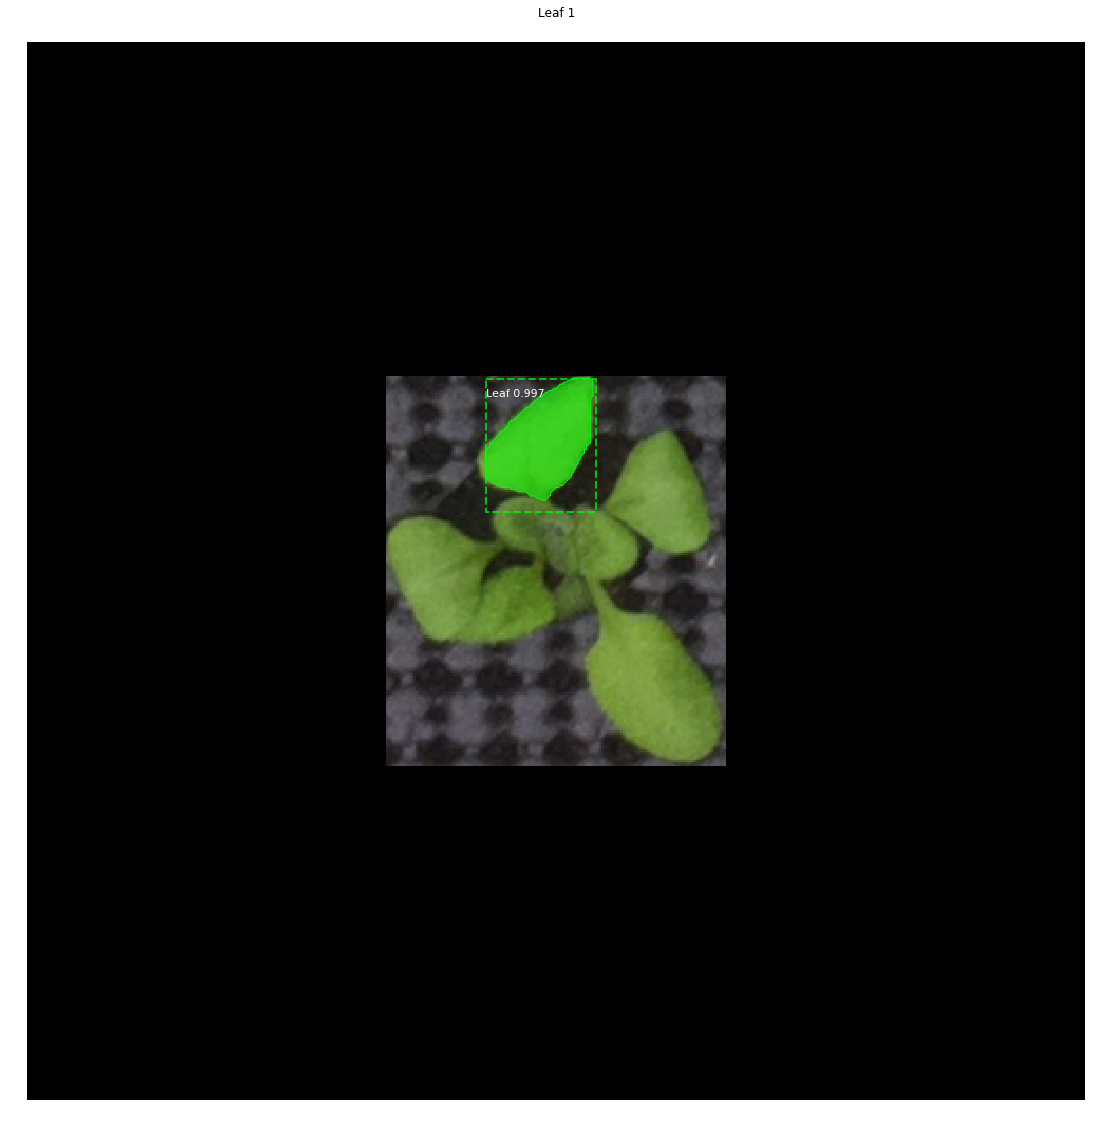

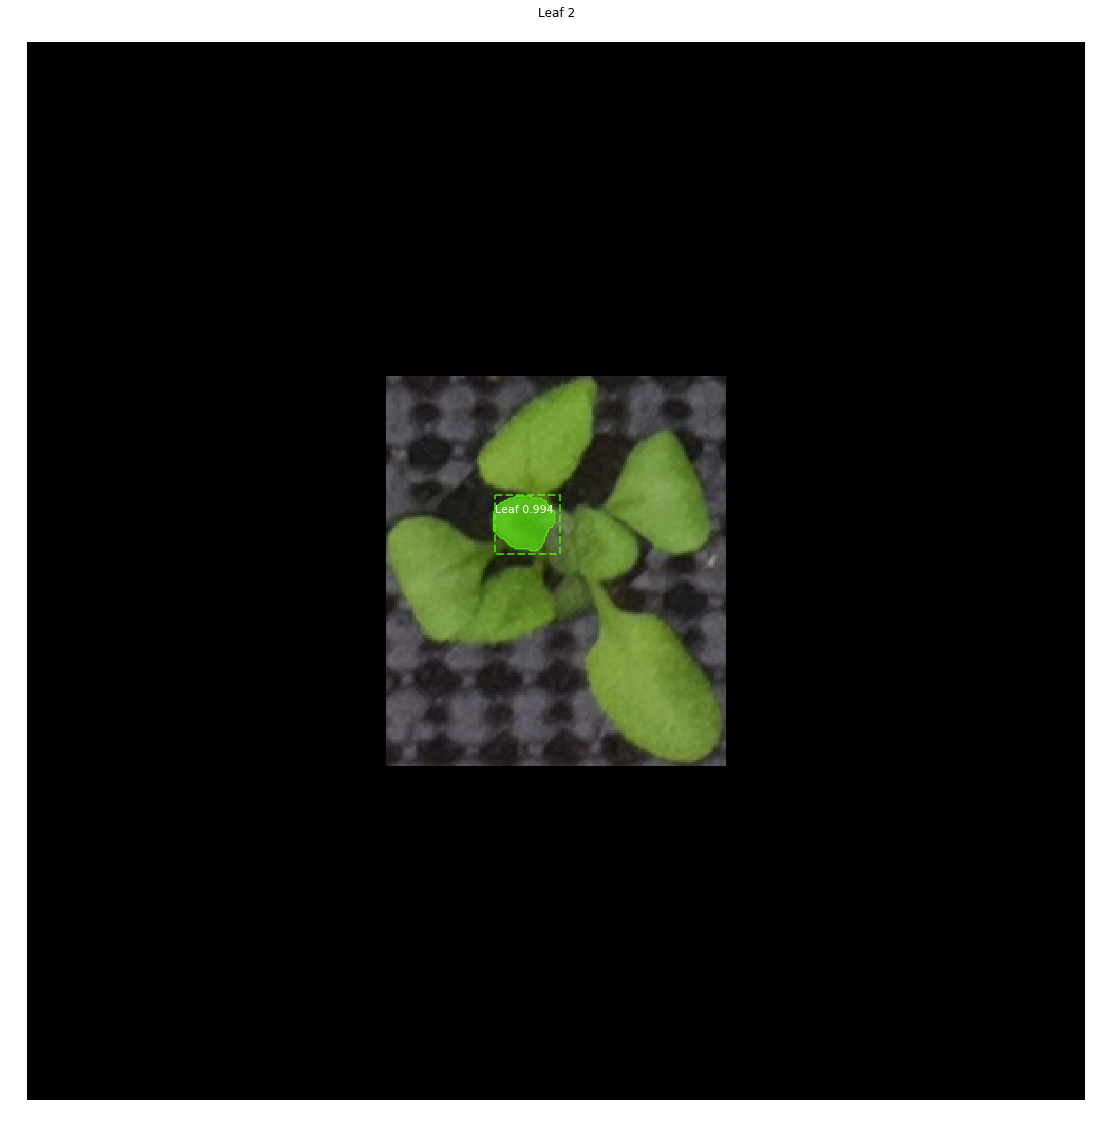

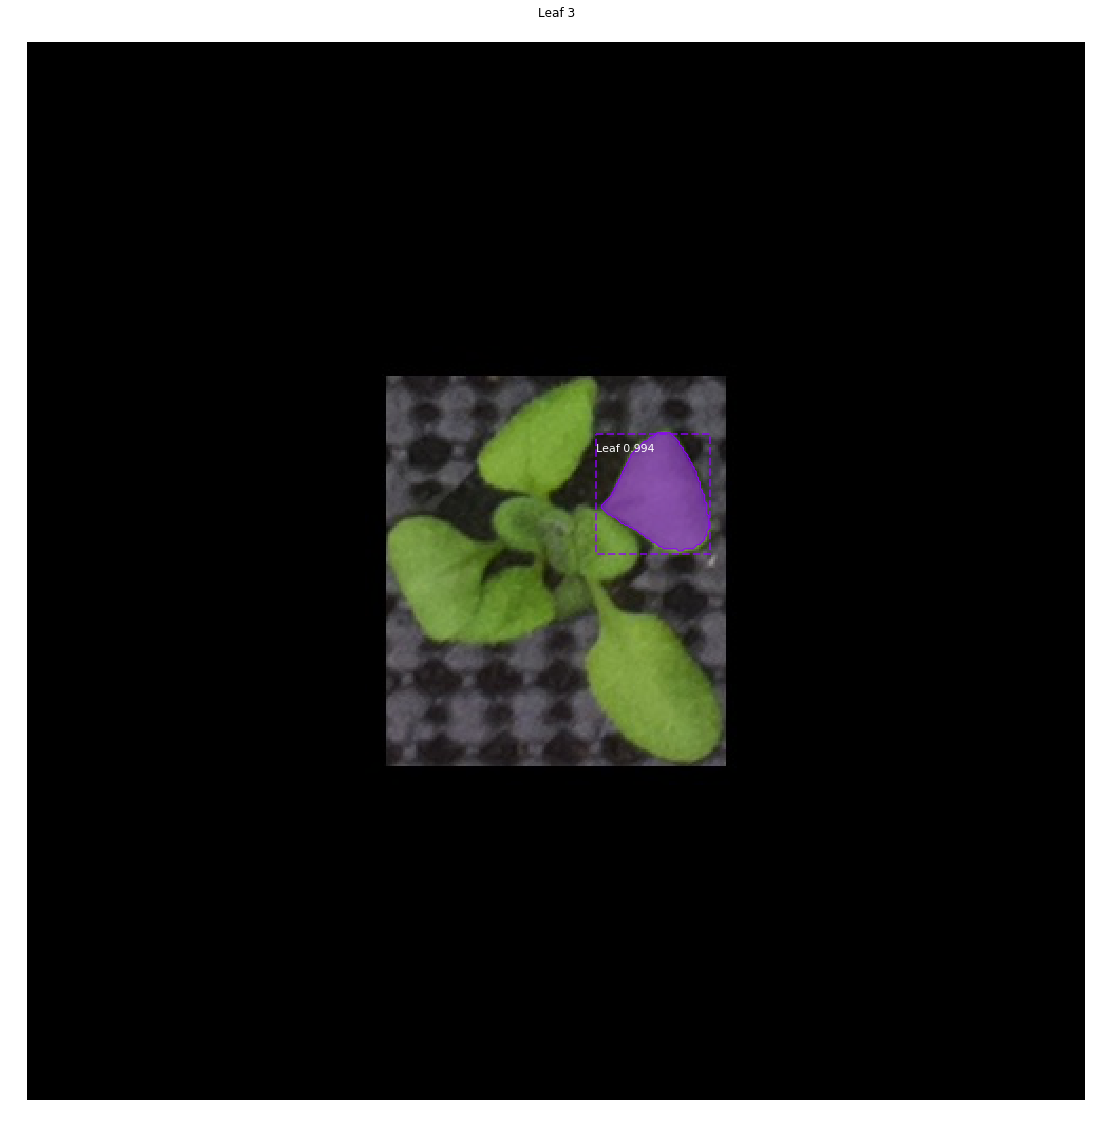

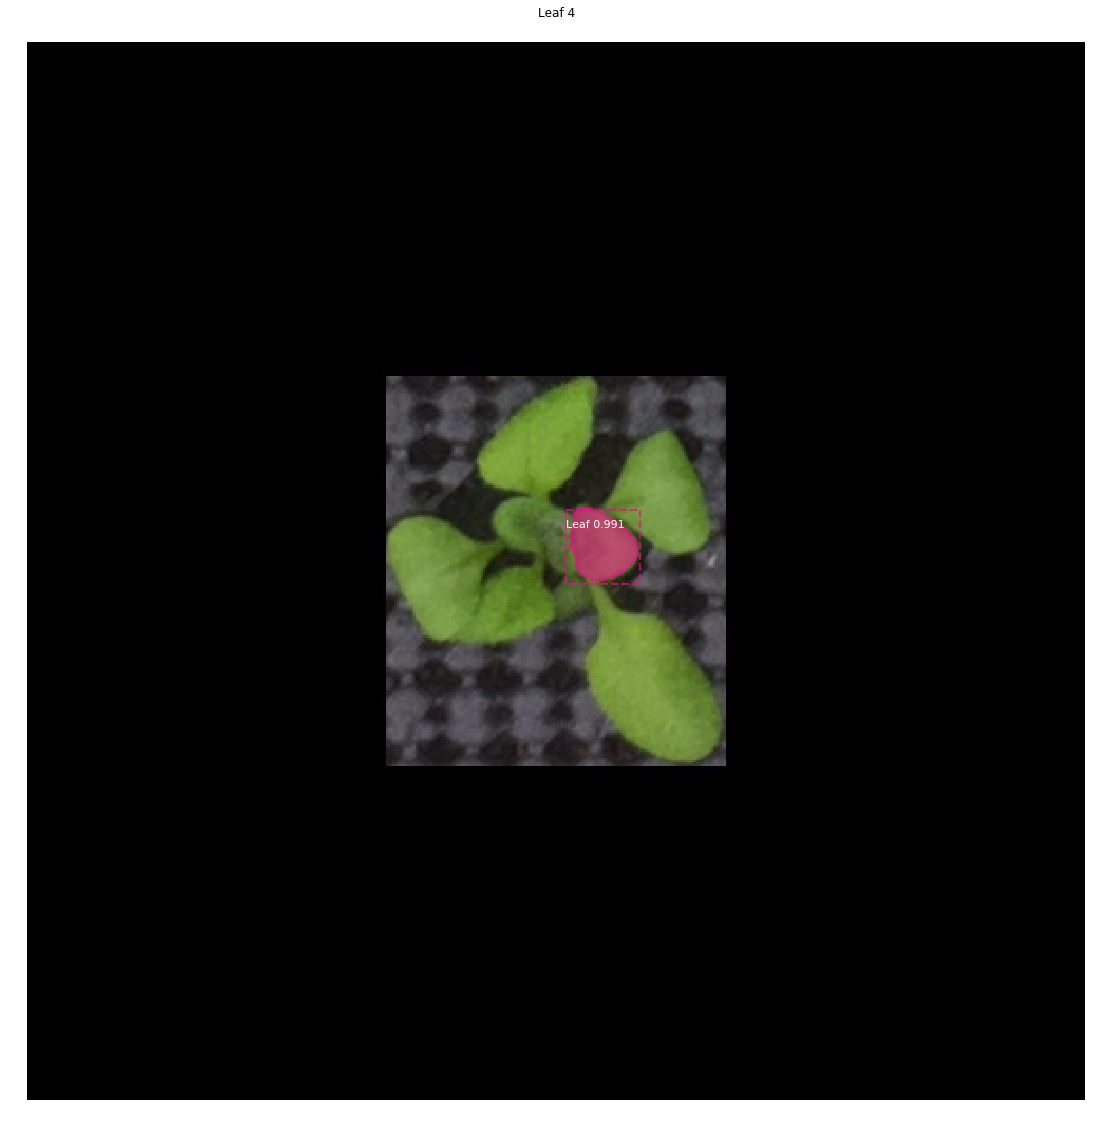

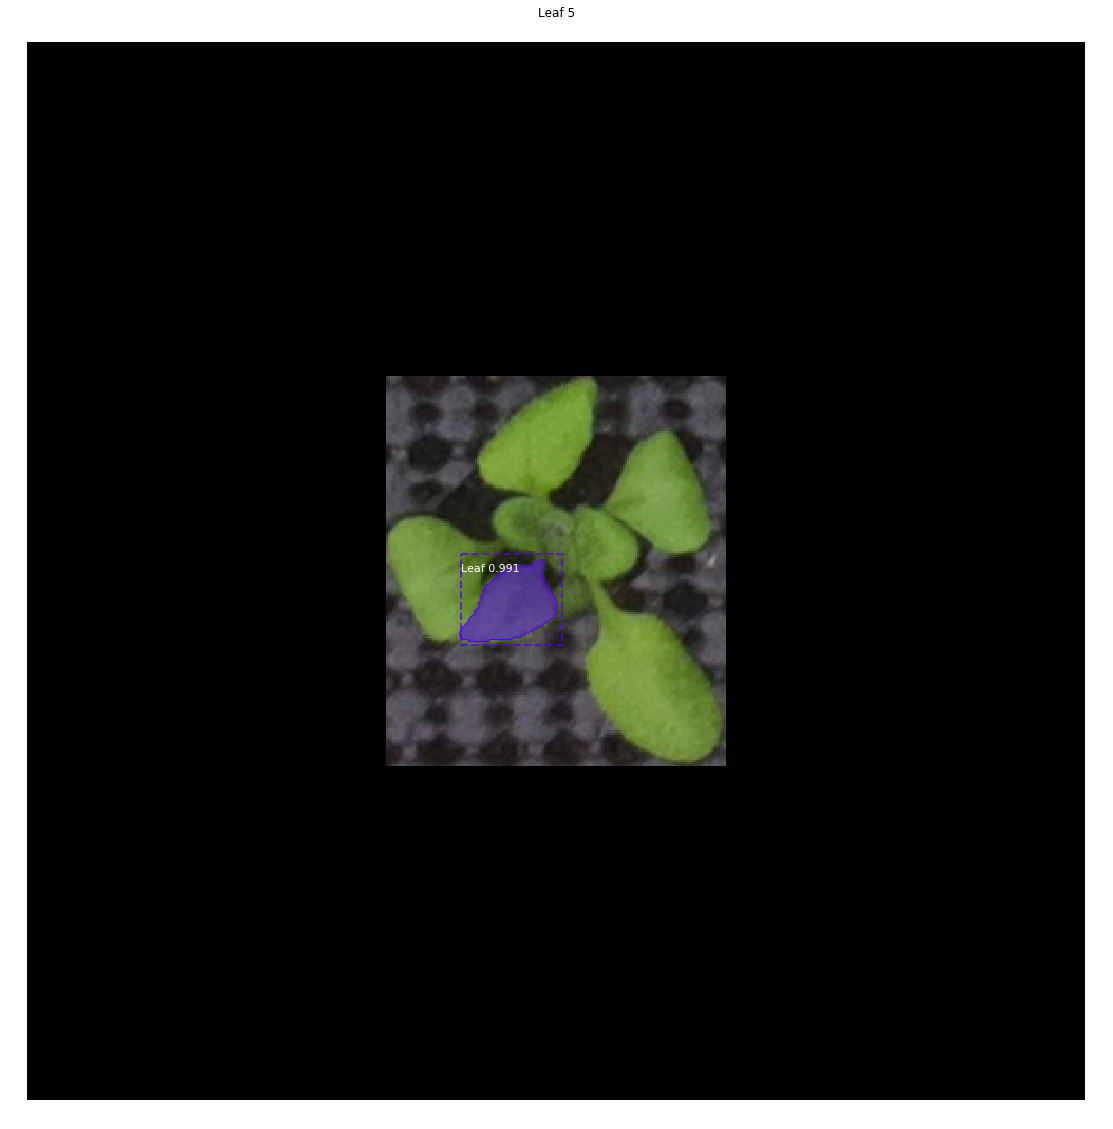

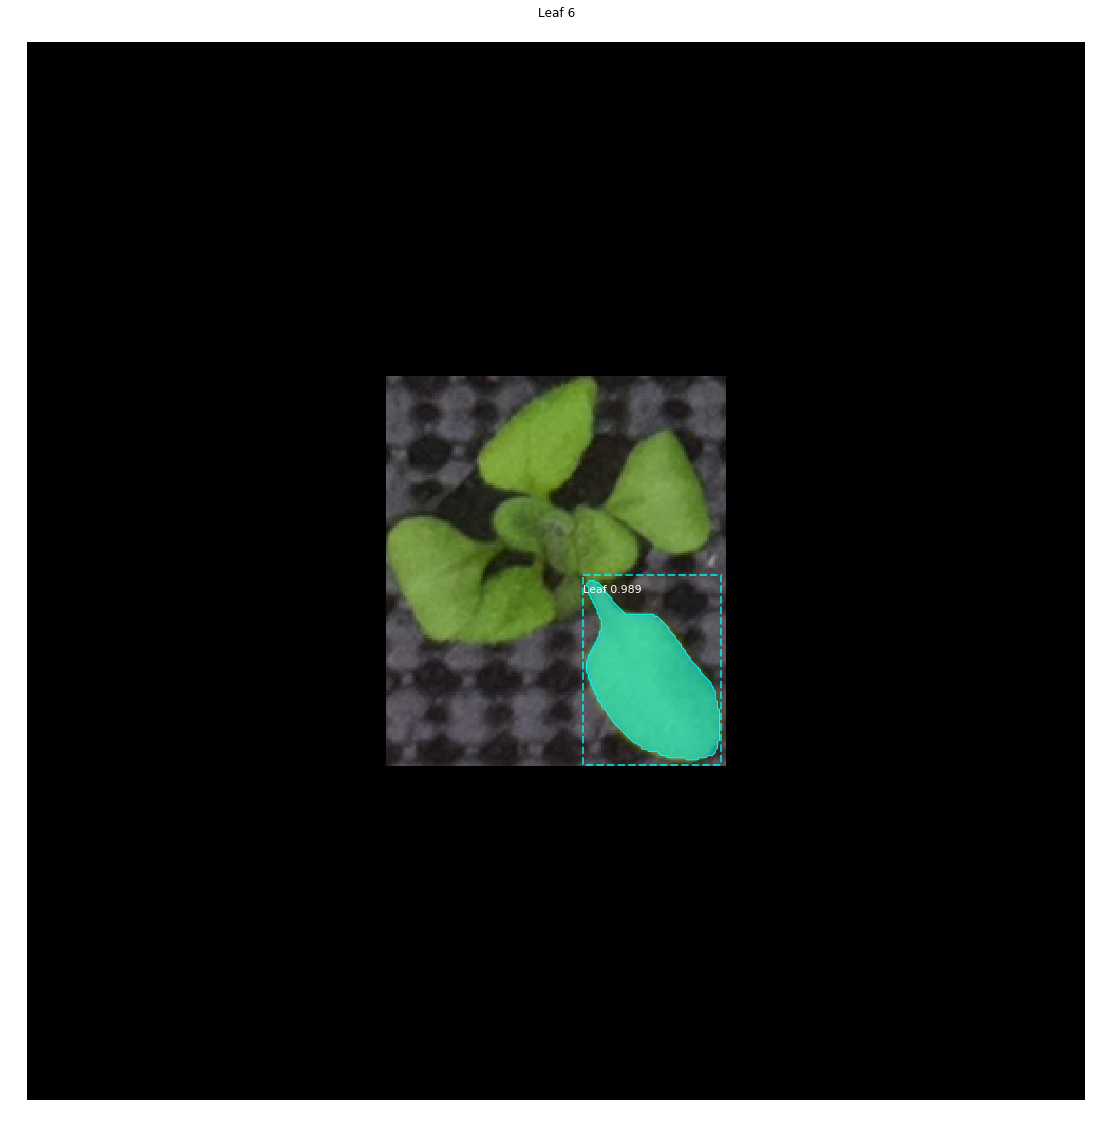

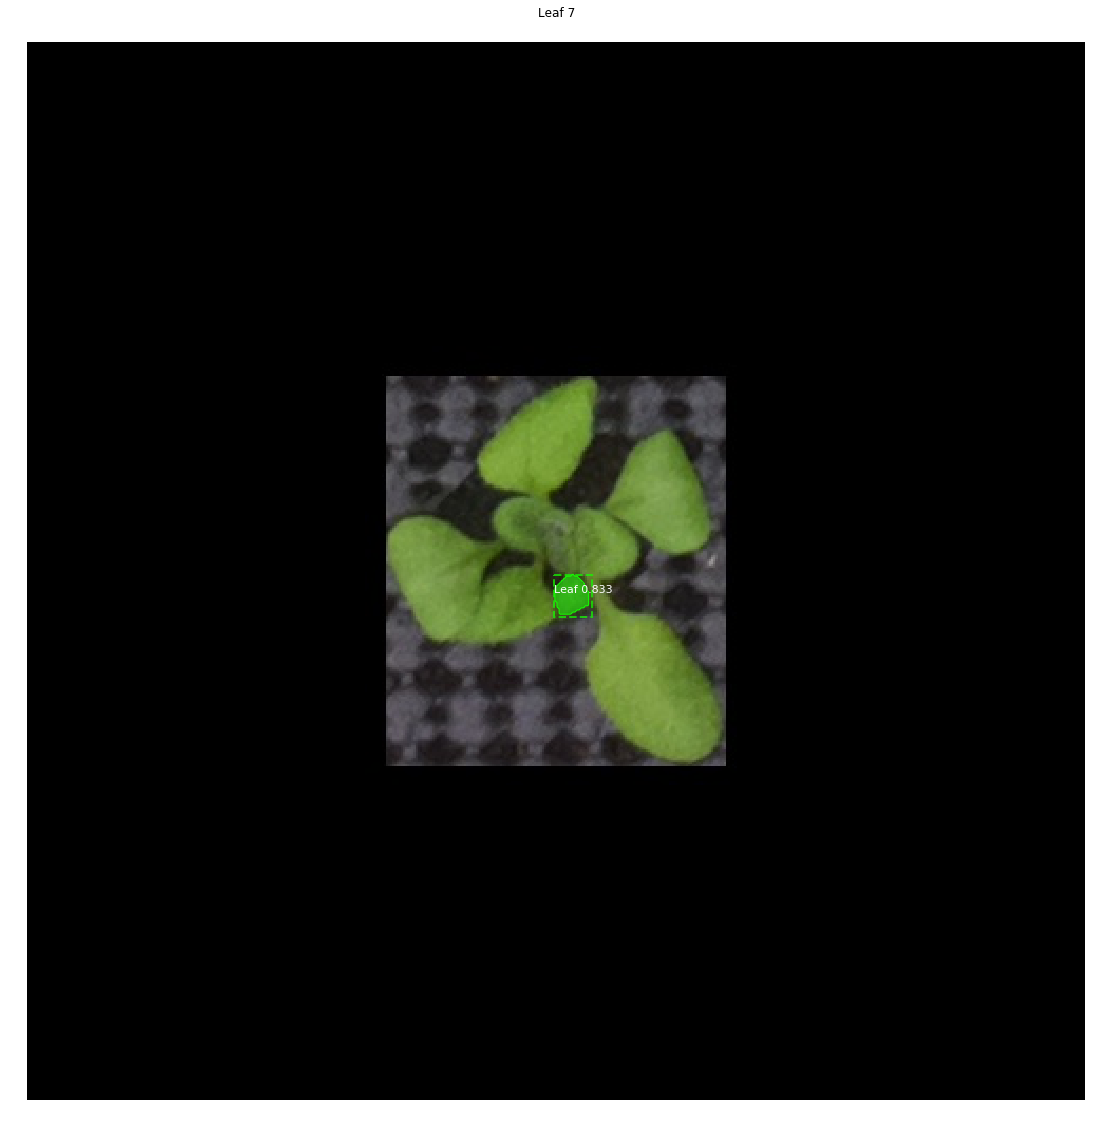

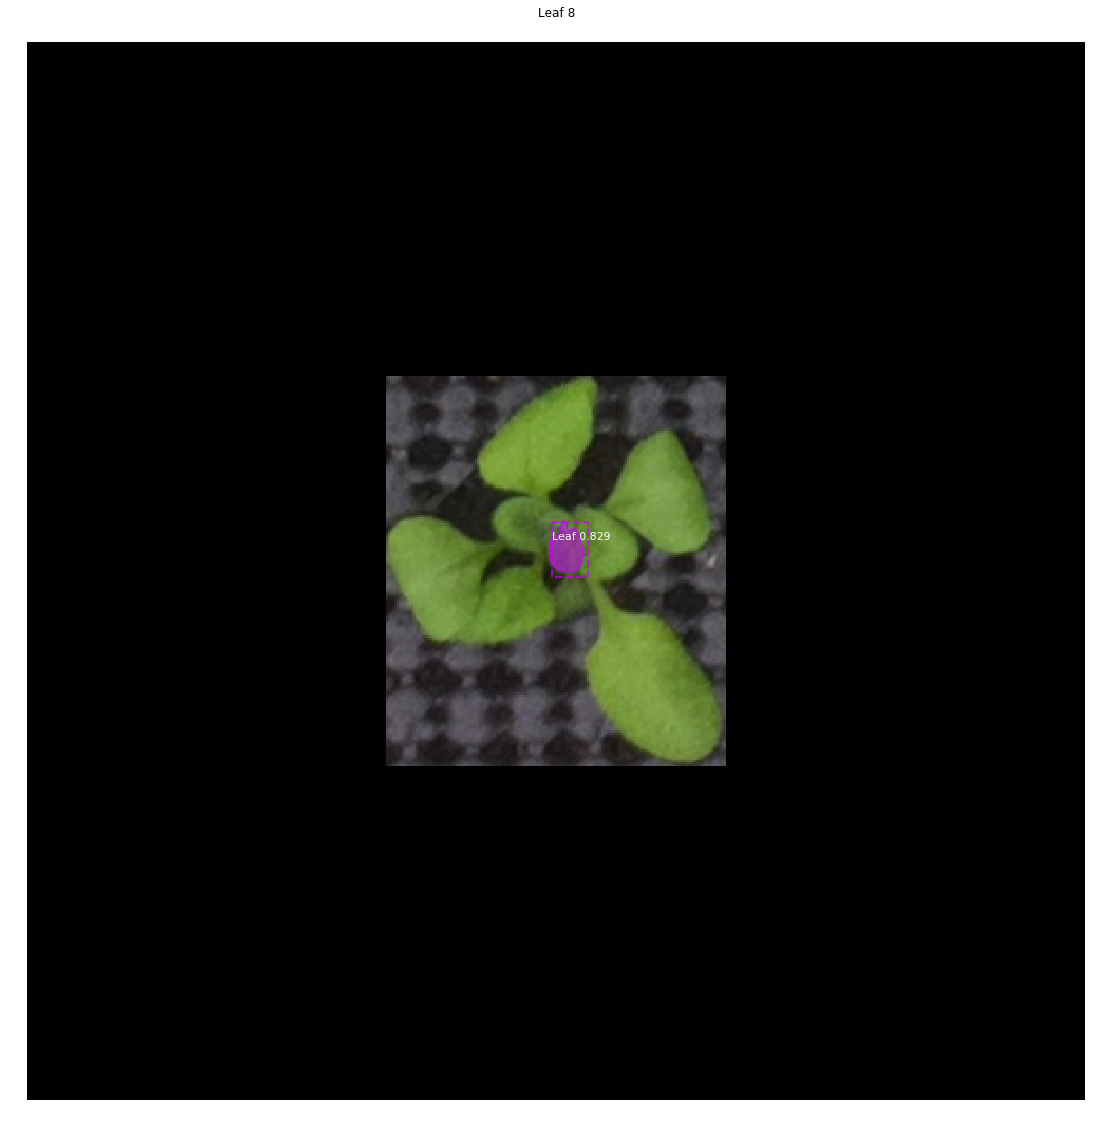

In [5]:
## show one randomly selected image as an example
instance_seg.inferencing_random_sample()

If you run the following block, it will loop over all files in the file list you defined. Note it might take some time for the process to finish.

You can also explore the sample results here: \
result/segmentation/2020-07-27-12-37/segmentation.

In [6]:
## get the result of all images
instance_seg.inferencing_all()

Processing 1 images
image                    shape: (501, 500, 3)         min:    0.00000  max:  166.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:   47.20000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32
1 images done. The last one is 10.9.1.241_pos-165-003-020_2019-10-22-11-05_crop-img17.jpg
Processing 1 images
image                    shape: (499, 501, 3)         min:    0.00000  max:  171.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:   52.20000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32
2 images done. The last one is 10.9.1.241_pos-165-003-020_2019-10-23-11-05_crop-img17.jpg
Processing 1 ima

If you are not in the interactive tutorial (binder), you can direct yourself to this folder to check the saved result by running the following block:

In [7]:
instance_seg.segmentation_dir

'result/segmentation/2020-07-27-12-37/segmentation'

### (Optional) Quality control of segmentation
For the segmentation result we currently have, sometimes we would observe the segmentation is not good enough (the issue should be better dealt with in next version of this tool). The following block mainly deal with 2 cases:

- One segmentation mask overlaps with other two masks. In this case the mask will be removed.
- Two segmentation masks overlap a large amount on each other. In this case the mask with a larger area will be kept. 

Feel free to check the results with quality controlled here: \
result/segmentation/2020-07-27-12-37/segmentation/updated

In [8]:
instance_seg.quality_control_instance_seg()

File 10.9.1.241_pos-165-003-020_2019-10-22-11-05_crop-img17 type 1: {}
File 10.9.1.241_pos-165-003-020_2019-10-22-11-05_crop-img17 type 2: {}.

File 10.9.1.241_pos-165-003-020_2019-10-23-11-05_crop-img17 type 1: {}
File 10.9.1.241_pos-165-003-020_2019-10-23-11-05_crop-img17 type 2: {}.

File 10.9.1.241_pos-165-003-020_2019-10-24-11-05_crop-img17 type 1: {}
File 10.9.1.241_pos-165-003-020_2019-10-24-11-05_crop-img17 type 2: {}.

File 10.9.1.241_pos-165-003-020_2019-10-25-11-05_crop-img17 type 1: {}
File 10.9.1.241_pos-165-003-020_2019-10-25-11-05_crop-img17 type 2: {}.

File 10.9.1.241_pos-165-003-020_2019-10-26-11-05_crop-img17 type 1: {5: array([7]), 6: array([7]), 7: array([5, 6])} 

File 10.9.1.241_pos-165-003-020_2019-10-26-11-05_crop-img17 type 2: {}.

File 10.9.1.241_pos-165-003-020_2019-10-27-11-05_crop-img17 type 1: {}
File 10.9.1.241_pos-165-003-020_2019-10-27-11-05_crop-img17 type 2: {}.

File 10.9.1.241_pos-165-003-020_2019-10-28-11-05_crop-img17 type 1: {7: array([8]), 8: a